In [65]:
from nltk.lm.preprocessing import pad_both_ends
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from cosine_cost import CosineCost, plot_breakpoints
from discourse import plot_discourse, glyph_bound

import numpy as np

In [2]:
# Read and preprocess data

with open('data/I.csv', 'r') as file:
    raw_data_I = [line.split(',')[1][:-1] for line in file.readlines()]

# We remove glyph 999 (separator)

clean_lines_I = [line.split('-') for line in raw_data_I]

In [3]:
# Automatic extraction of the triads by splitting
# whenever we find glyph 076 as an appendage

sequences_I = []

for line in clean_lines_I:
    i = 0
    j = 1
    while j < len(line):
        if line[j][-4:] == '.076':
            sequences_I.append(line[i:j])
            i = j
        j += 1

# We will add a special token to represent glyph 076
# when appended to the first glyph of the triad

for i in range(len(sequences_I)):
    sequences_I[i][0] = sequences_I[i][0][:-4]
    sequences_I[i].insert(1, '<076>')

sequences_I = [sequence for sequence in sequences_I if len(sequence) >= 3]

In [4]:
# Glyphs that most likely precede 076
padded = [list(pad_both_ends(sequence, 2)) for sequence in sequences_I]
bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_documents(padded)
finder.apply_freq_filter(2)
finder.apply_ngram_filter(lambda *w: w[1] != '<076>')
finder.score_ngrams(bigram_measures.likelihood_ratio)[:10]

[(('090', '<076>'), 104.18249202546576),
 (('430', '<076>'), 60.726069948803506),
 (('606', '<076>'), 39.68969095216505),
 (('604', '<076>'), 34.77099326590314),
 (('202', '<076>'), 19.277930691171235),
 (('700', '<076>'), 16.288739808273256),
 (('021:090', '<076>'), 15.414521408641146),
 (('633', '<076>'), 14.183995862849276),
 (('099', '<076>'), 13.842502707586984),
 (('', '<076>'), 11.555033950089154)]

In [5]:
# Glyphs that most likely follow 076
finder = BigramCollocationFinder.from_documents(padded)
finder.apply_freq_filter(2)
finder.apply_ngram_filter(lambda *w: w[0] != '<076>')
finder.score_ngrams(bigram_measures.likelihood_ratio)[:10]

[(('<076>', '011'), 54.84465022137523),
 (('<076>', '070'), 41.35367396741711),
 (('<076>', '071'), 32.06708834490003),
 (('<076>', '532a'), 31.996642416094524),
 (('<076>', '530'), 27.8431202504172),
 (('<076>', '057'), 23.145272121484666),
 (('<076>', '010.079f'), 21.29970139015016),
 (('<076>', '020.010'), 20.648335024578703),
 (('<076>', '004f?'), 18.933576674843927),
 (('<076>', '006'), 18.07360498274752)]

In [6]:
vectorizer = CountVectorizer(analyzer="word", token_pattern = '[0-9]+[a-zAZ]*[.0-9]*[a-zAZ]*')
vectorized_text = vectorizer.fit_transform([' '.join(line) for line in clean_lines_I])

[6, 14]


(<Figure size 288x288 with 1 Axes>, <AxesSubplot:>)

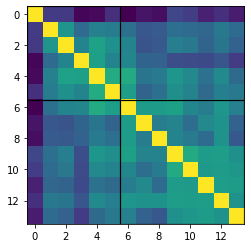

In [33]:
plot_breakpoints(vectorized_text, 1)

In [34]:
tf_vectorizer = TfidfVectorizer(analyzer="word", token_pattern = '[0-9]+[a-zAZ]*[.0-9]*[a-zAZ]*')
tf_vectorized_text = tf_vectorizer.fit_transform([' '.join(line) for line in clean_lines_I])

In [35]:
# Most distinctive glyphs of lines 0-5
tf_vectorizer.get_feature_names_out()[list(set(np.argmax(vectorized_text.toarray()[:6,:], axis=1)))]

array(['600', '076', '999'], dtype=object)

In [36]:
# Most distinctive glyphs of lines 6-13
tf_vectorizer.get_feature_names_out()[list(set(np.argmax(vectorized_text.toarray()[6:,:], axis=1)))]

array(['071', '076', '011', '090', '090.076', '999'], dtype=object)

In [37]:
full_text = []
for line in clean_lines_I:
    full_text.extend(line)

In [62]:
sel_glyphs = []

for glyph in set(full_text):
    if full_text.count(glyph) > 3:
        bounds = glyph_bound(glyph, clean_lines_I)
        if bounds[0] >= 6 or bounds[1] <= 6:
            sel_glyphs.append(glyph)

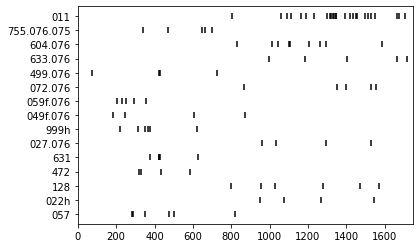

In [64]:
# Distribution of glyphs that appear exclusively
# in the first or second halves

plot_discourse(sel_glyphs, full_text)